# Depression Research Using Machine learning

# Importing Libraries

In [2]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
control_1 = pd.read_csv(r"C:\Users\Omkar Bankar\Downloads\depresjon\data\control\control_1.csv")
condition_1 = pd.read_csv(r"C:\Users\Omkar Bankar\Downloads\depresjon\data\condition\condition_1.csv")
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [4]:
control_1.head()

timestamp        date  activity
0  2003-03-18 15:00:00  2003-03-18        60
1  2003-03-18 15:01:00  2003-03-18         0
2  2003-03-18 15:02:00  2003-03-18       264
3  2003-03-18 15:03:00  2003-03-18       662
4  2003-03-18 15:04:00  2003-03-18       293

In [5]:
condition_1.head()

timestamp        date  activity
0  2003-05-07 12:00:00  2003-05-07         0
1  2003-05-07 12:01:00  2003-05-07       143
2  2003-05-07 12:02:00  2003-05-07         0
3  2003-05-07 12:03:00  2003-05-07        20
4  2003-05-07 12:04:00  2003-05-07       166

In [6]:
condition_1.describe()

activity
count  23244.000000
mean     146.948030
std      294.592424
min        0.000000
25%        0.000000
50%        9.000000
75%      172.000000
max     3526.000000

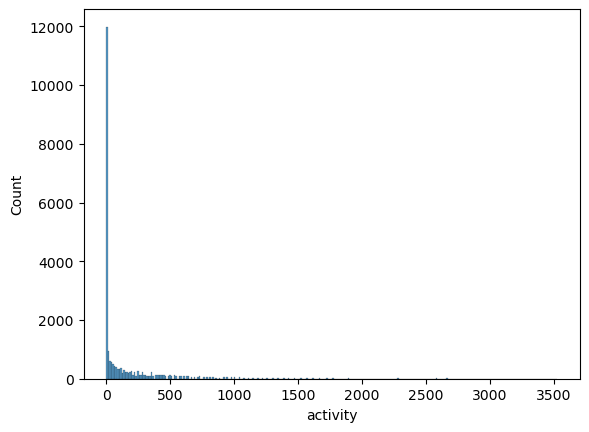

In [7]:
sns.histplot(x='activity', data=condition_1)
plt.show()

In [8]:
condition_1['activity'].skew()

3.8823677090908344

In [9]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

0.2771381485812395

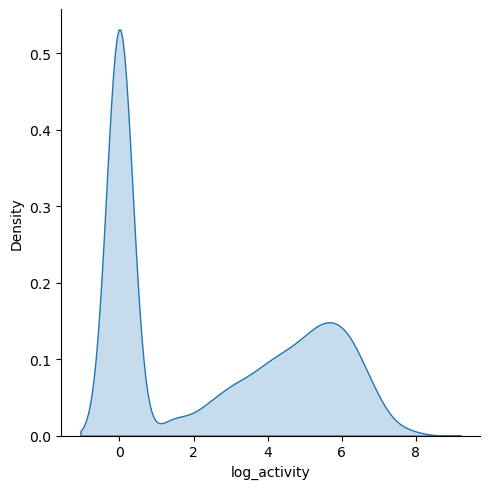

In [10]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)
plt.show()

In [11]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

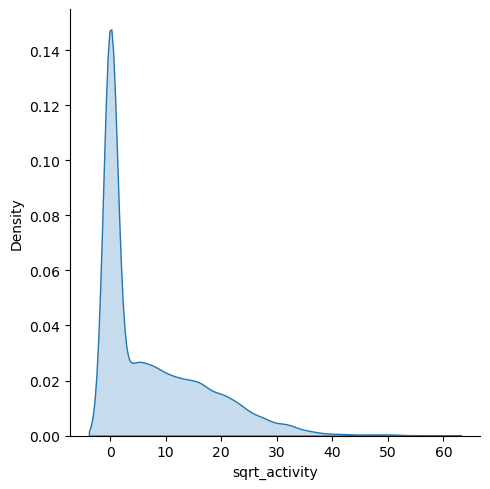

In [12]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)
plt.show()

In [13]:
condition_1.describe()

activity  log_activity  sqrt_activity
count  23244.000000  23244.000000   23244.000000
mean     146.948030      2.562035       7.416512
std      294.592424      2.626393       9.588917
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       0.000000
50%        9.000000      2.302585       3.000000
75%      172.000000      5.153292      13.114877
max     3526.000000      8.168203      59.380131

In [14]:
control_1['activity'].skew()

5.039169993104665

In [15]:
control_1.describe()

activity
count  51611.000000
mean      98.545078
std      289.655317
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max     6117.000000

In [16]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

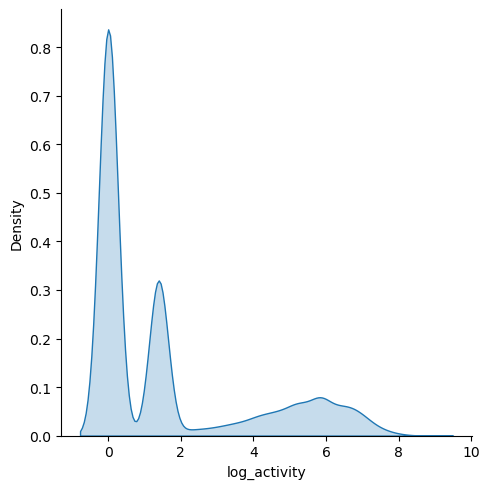

In [17]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)
plt.show()

In [18]:
condition_1.head()

timestamp        date  activity  log_activity  sqrt_activity
0  2003-05-07 12:00:00  2003-05-07         0      0.000000       0.000000
1  2003-05-07 12:01:00  2003-05-07       143      4.969813      11.958261
2  2003-05-07 12:02:00  2003-05-07         0      0.000000       0.000000
3  2003-05-07 12:03:00  2003-05-07        20      3.044522       4.472136
4  2003-05-07 12:04:00  2003-05-07       166      5.117994      12.884099

In [19]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

date  log_activity
0  2003-05-07      3.752204
1  2003-05-08      2.931977
2  2003-05-09      2.593095
3  2003-05-10      2.910573
4  2003-05-11      2.561446

In [20]:
def combine_data(path):
    files = [file for file in os.listdir(path) if file.endswith('.csv')]
    combine_df = []
    
    for file in files:
        source = file.split('.')[0]
        file_path = os.path.join(path, file)
        X = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')
        X['source'] = source
        combine_df.append(X)
        
    return combine_df

In [21]:
combine_df_condition=combine_data(r"C:\Users\Omkar Bankar\Downloads\depresjon\data\condition")

In [22]:
conditions = []
for condition in combine_df_condition:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [23]:
combine_df_controls = combine_data(r"C:\Users\Omkar Bankar\Downloads\depresjon\data\control")

In [24]:
controls = []
for control in combine_df_controls:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

In [25]:
conditions = sorted(conditions, key=lambda x: x.source[1])
controls = sorted(controls, key=lambda x: x.source[1])

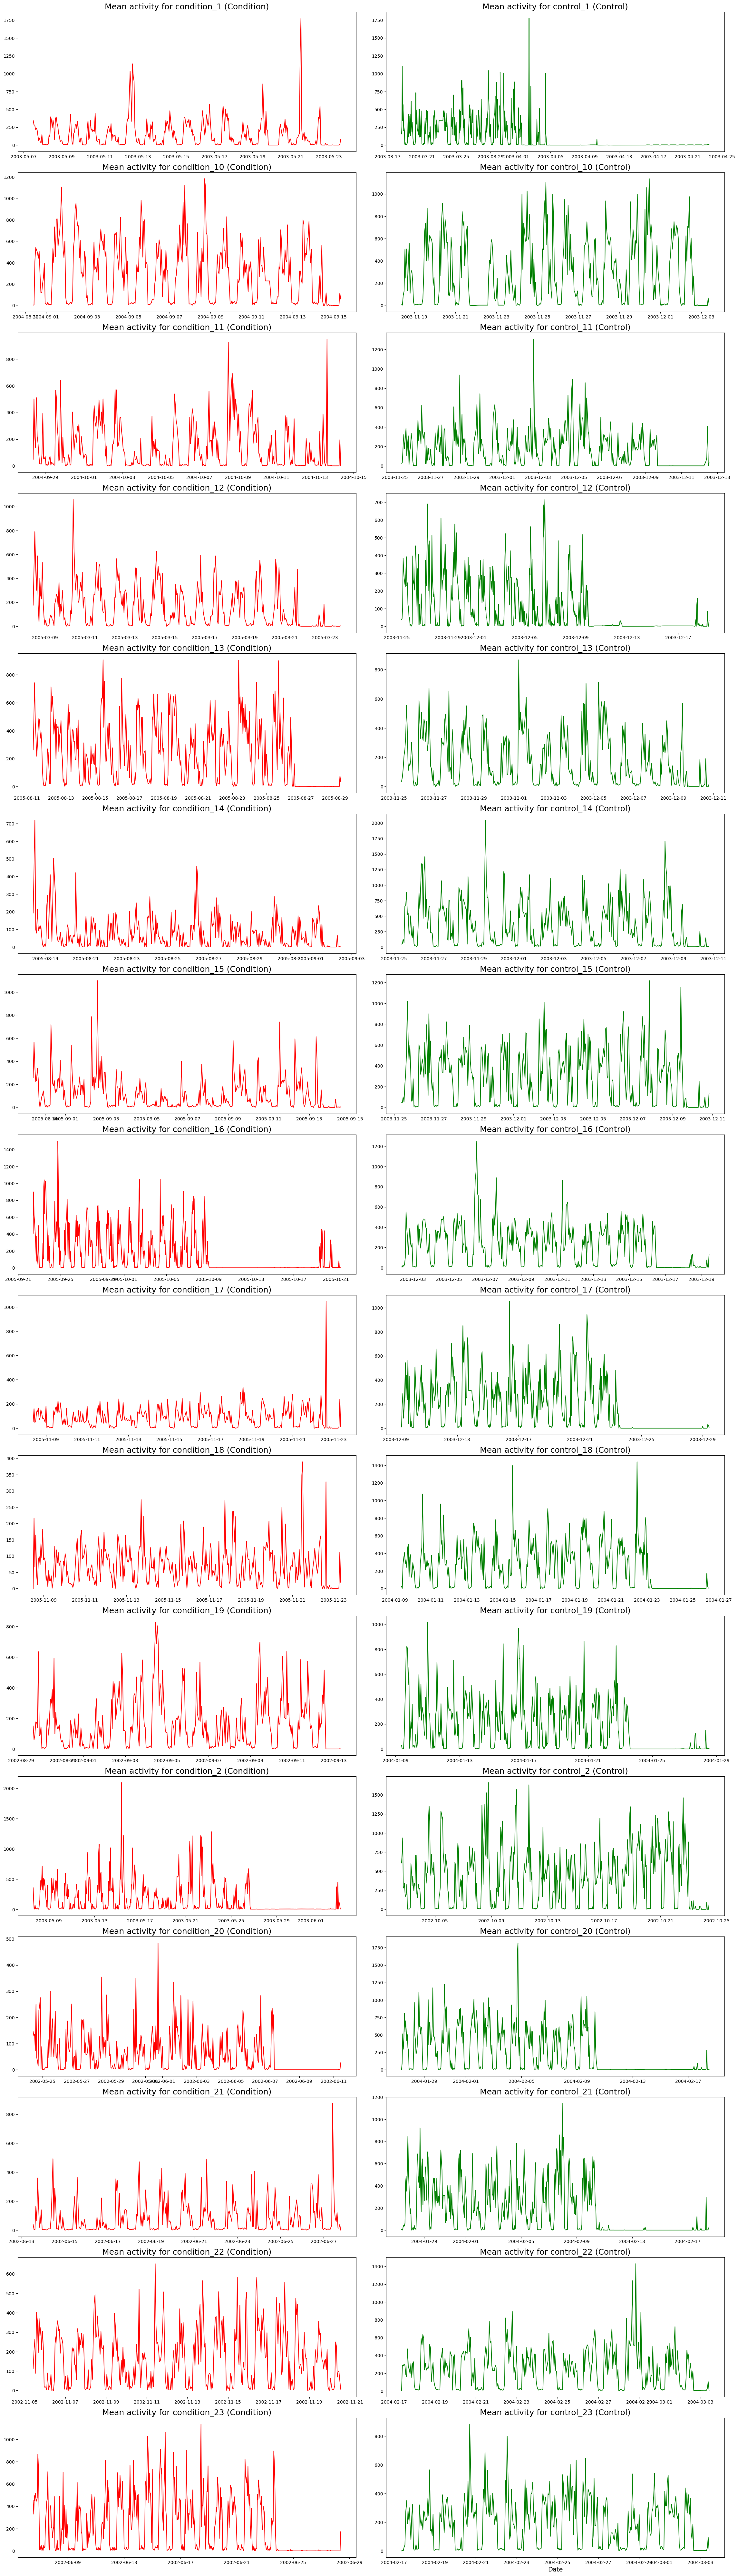

In [26]:
fig, axes = plt.subplots(16, 2, figsize=(23, 80))
cnt_condition = 0
cnt_control = 0

for i in range(16):
    if cnt_condition < 16:
        condition = conditions[cnt_condition]
        axes[i, 0].plot(condition.index, condition.mean_activity, color='r')
#         print(condition.source[1])
        axes[i, 0].set_title(f'Mean activity for {condition.source[1]} (Condition)', fontsize=18)
        cnt_condition += 1
    
    if cnt_control < 16:
        control = controls[cnt_control]
        axes[i, 1].plot(control.index, control.mean_activity, color='g')
#         print(control.source[1])
        axes[i, 1].set_title(f'Mean activity for {control.source[1]} (Control)', fontsize=18)
        cnt_control += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition and control groups.jpg', dpi=100)
plt.show()

In [27]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

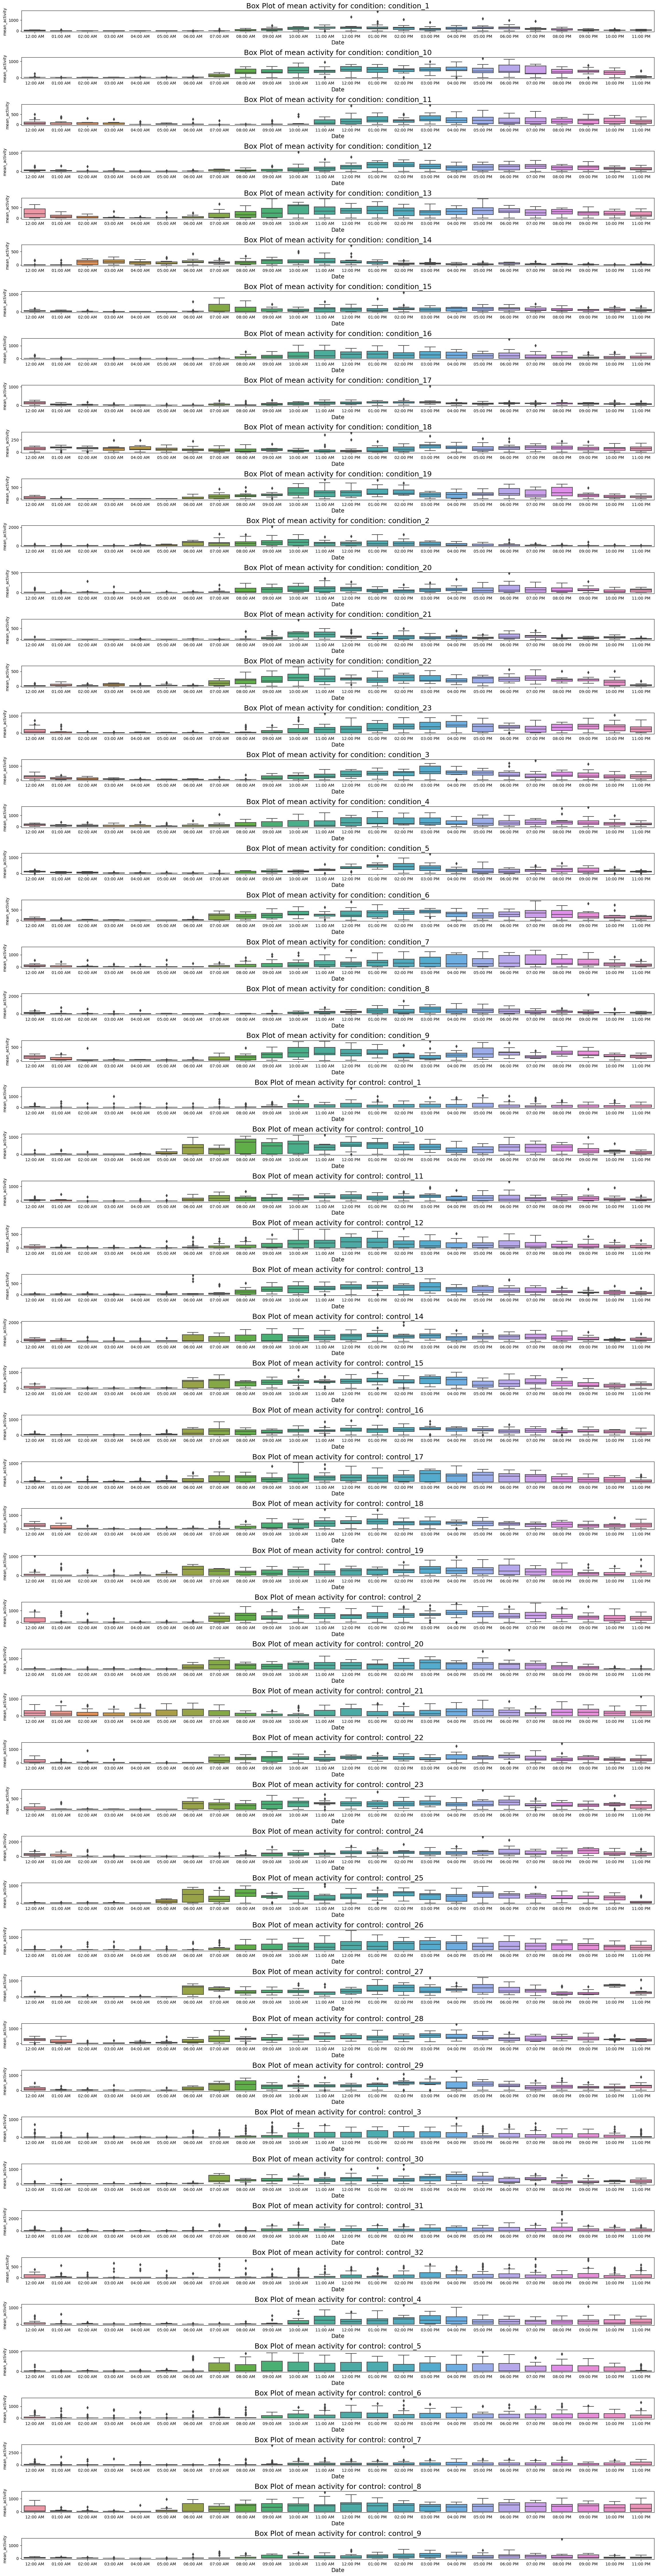

In [28]:
# Draw Plot
fig, axes = plt.subplots(55, 1, figsize=(23, 90))

# Iterate over conditions and controls
for i in range(55):
    if i < 23:
        df = conditions[i].reset_index()
        source_type = 'condition'
    else:
        df = controls[i - 23].reset_index()
        source_type = 'control'

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))

    # Plot box plot
    ax = axes[i]
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=ax)
    ax.set_title(f'Box Plot of mean activity for {source_type}: {df.source[1]}', fontsize=18)
    ax.set_xlabel('Date', fontsize=14)

fig.tight_layout(pad=1.0)
plt.show()

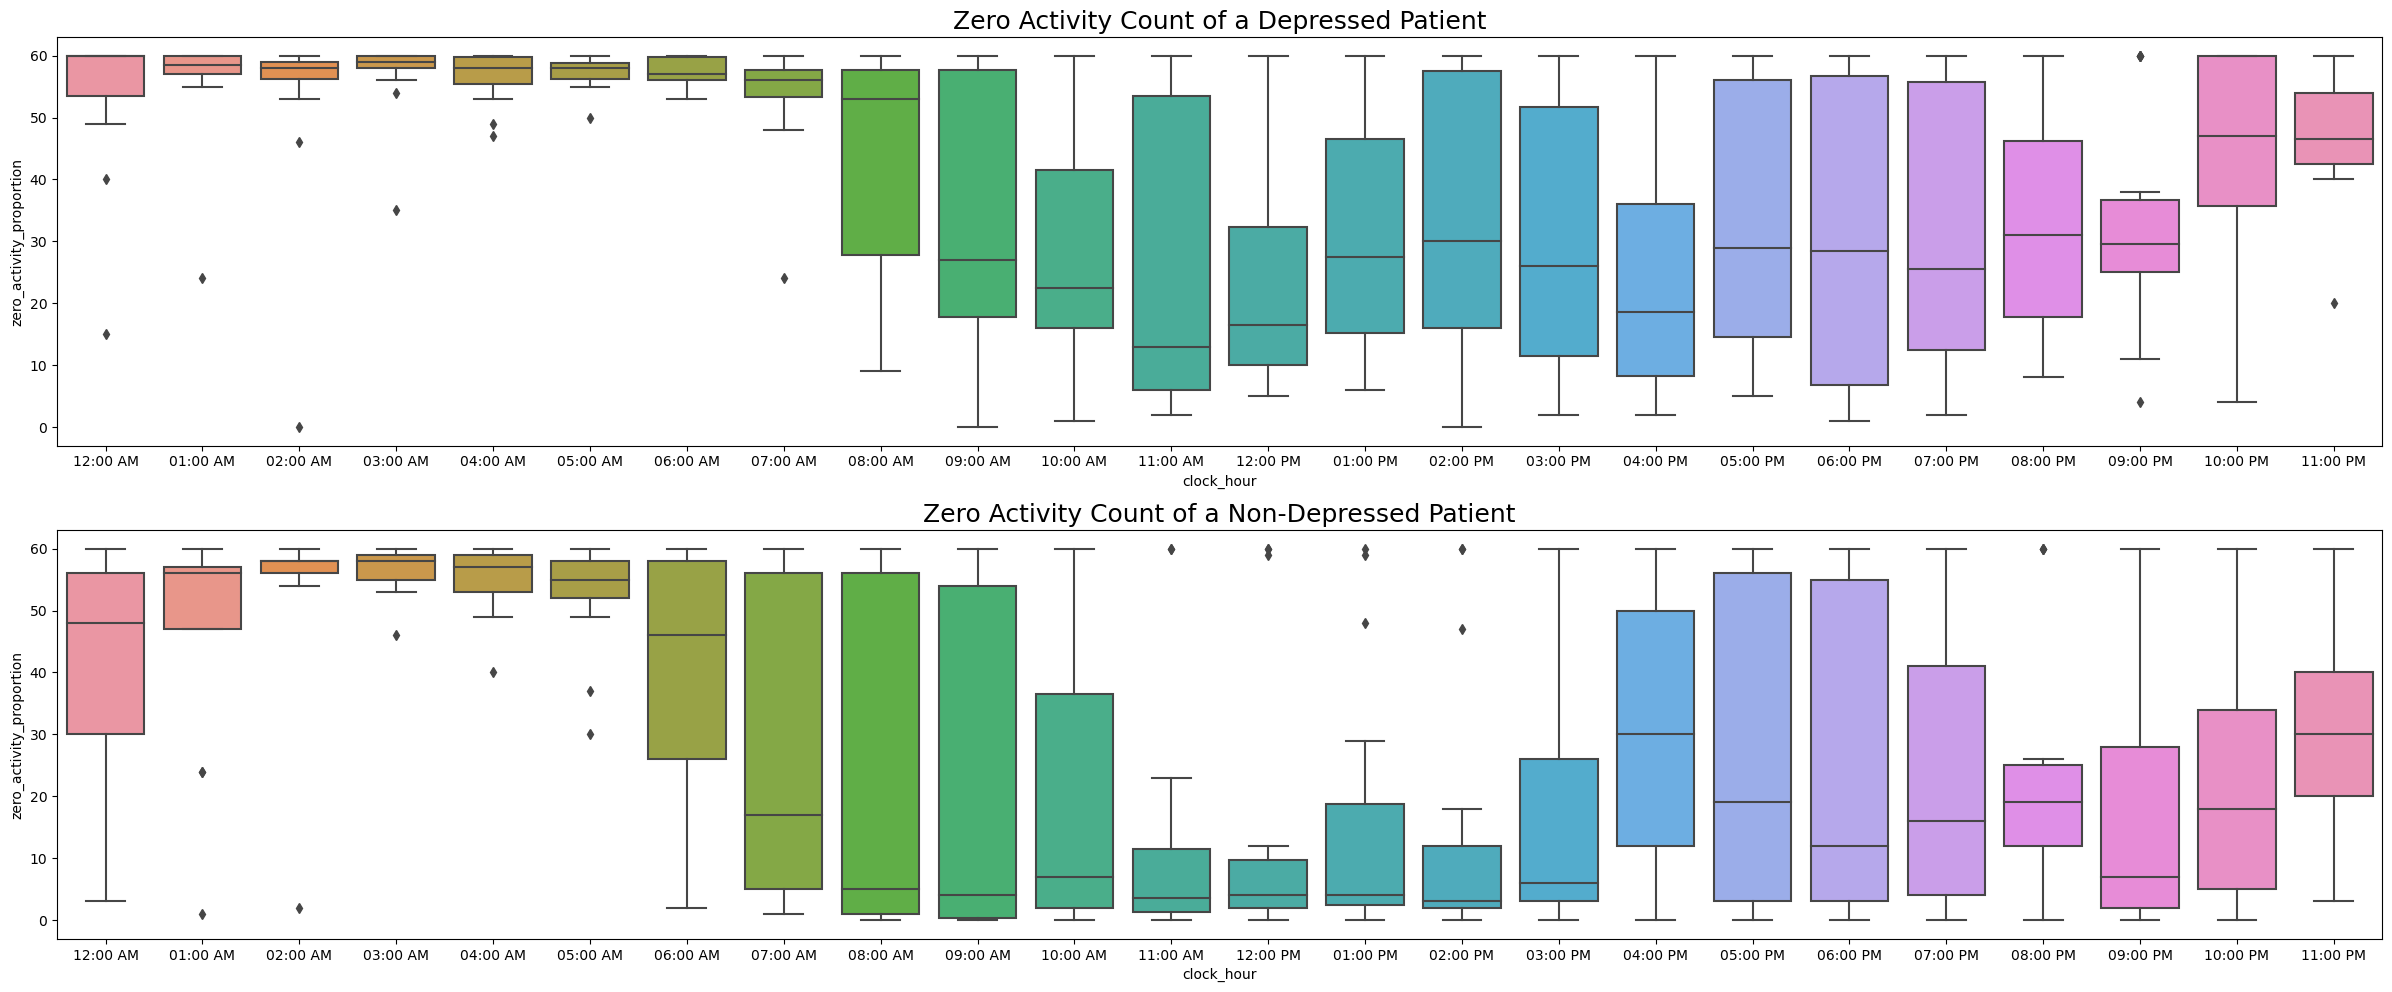

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

Model Building

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [31]:
def nextday(dates):
    for date in dates:
        yield date

In [32]:
def zero_count(series):
    return list(series).count(0)

In [33]:
def extract_features(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': list(X[mask]['log_activity']).count(0)
    }
    return d

In [34]:
class ExtractData:
    def __init__(self, path):
        self.path = path
        self.X = []

    def transform(self):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in dates:
                    d = extract_features(X, date)
                    d['source'] = condition
                    self.X.append(d)
                
        return pd.DataFrame(self.X)
    
    def fit_transform(self):
        return self.transform()

In [35]:
class ExtractData:
    def __init__(self, path):
        self.path = path
        self.X = []

    def transform(self):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                file_path = os.path.join(self.path, filepath)
                X = pd.read_csv(file_path)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in dates:
                    d = extract_features(X, date)
                    d['source'] = condition
                    self.X.append(d)
                
        return pd.DataFrame(self.X)
     
    def fit_transform(self):
        return self.transform()

In [36]:
e = ExtractData(r'C:\Users\Omkar Bankar\Downloads\depresjon\data\condition')
conditions = e.fit_transform()
conditions['state'] = 1

In [37]:
e = ExtractData(path=r"C:\Users\Omkar Bankar\Downloads\depresjon\data\control")
controls = e.fit_transform()
controls['state'] = 0

Steps for Model Building

In [38]:
conditions.tail()

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
400           2.836361          2.604526               0.0          7.789869   
401           3.317860          2.664783               0.0          7.945201   
402           3.174113          2.653188               0.0          7.664816   
403           2.860525          2.617277               0.0          7.696213   
404           1.648750          2.476757               0.0          7.602900   

     zero_proportion_activity       source  state  
400                       578  condition_9      1  
401                       491  condition_9      1  
402                       505  condition_9      1  
403                       572  condition_9      1  
404                       596  condition_9      1

In [39]:
e = ExtractData(path=r"C:\Users\Omkar Bankar\Downloads\depresjon\data\control")
controls = e.fit_transform()
controls['state'] = 0

In [40]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

C:\Users\Omkar Bankar\AppData\Local\Temp\ipykernel_15996\2945302482.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = controls.append(conditions, ignore_index=True)


mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           4.269175          2.536873               0.0          7.758761   
1           3.006935          2.636401               0.0          8.038512   
2           3.220895          2.683718               0.0          7.883069   
3           2.737783          2.699849               0.0          7.633854   
4           3.302284          2.641430               0.0          7.789869   

   zero_proportion_activity     source  state  
0                       106  control_1      0  
1                       557  control_1      0  
2                       516  control_1      0  
3                       657  control_1      0  
4                       520  control_1      0

In [41]:
full_df.shape

(1144, 7)

In [42]:
 # reshufle the dataset
full_df = full_df.sample(frac=1)

In [43]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report


class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))
        
    def get_model(self):
        return self.base_clf

In [45]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

XGBoost Algorithm

In [46]:
# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)

# Split the dataset into training and testing setsS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to DMatrix format (required by XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Set the XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Evaluate the model
report = classification_report(y_test, y_pred_binary)

print("XGBoost Report:")
print(report)

XGBoost Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90        97
           1       0.91      0.90      0.91       103

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200



Confusion matrix

In [49]:
print(y_test)
print(y_pred_binary)

[1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1
 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0
 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0
 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1
 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0
 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1

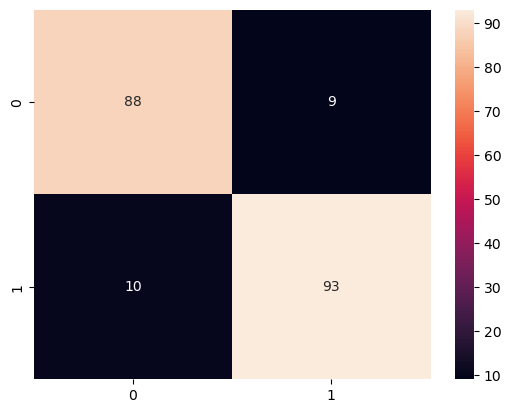

In [51]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_binary)
sns.heatmap(cm,annot=True)
plt.show()

Comparison of Xgboost algorithm and Random Forest Classifier

In [56]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

print("Random Forest Result:")
forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

print("XGBoost Report:")
print(report)

Random Forest Result:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        43
           1       0.39      0.75      0.51        12

    accuracy                           0.69        55
   macro avg       0.65      0.71      0.64        55
weighted avg       0.79      0.69      0.72        55

XGBoost Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90        97
           1       0.91      0.90      0.91       103

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200



Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx, elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                                                       test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))
        
    def get_model(self):
        return self.base_clf

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Train the decision tree model
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Generate classification report
D_report = classification_report(y_test, y_pred)


# Access the attributes
print("Classes:", clf.classes_)
print("Feature Importances:", clf.feature_importances_)
print("Tree Structure:", clf.tree_)
print("Number of Classes:", clf.n_classes_)
print("Number of Outputs:", clf.n_outputs_)

print(D_report)


Classes: [0 1]
Feature Importances: [0.62260253 0.01749503 0.05313228 0.084114   0.22265616]
Tree Structure: <sklearn.tree._tree.Tree object at 0x000001F3E217CF80>
Number of Classes: 2
Number of Outputs: 1
              precision    recall  f1-score   support

           0       0.84      0.81      0.83        97
           1       0.83      0.85      0.84       103

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200

